In [1]:
import torch
from data_fetcher import (
    generate_all_data,
    numpy,
    compare_model_answer,
    get_padded_image,
    compare_model_answer_with_actual,
    to_im,
    vec_to_im,
    numpy,
    get_line,
    extract_patches,
    get_line_data,
    rotate_and_flip_image,
)
from model import GPT
from showmethetypes import SMTT
import matplotlib.pyplot as plt
import einops
import pandas as pd

In [ ]:
tt = SMTT("torch")

In [ ]:
window = 12
d_model = 512 * 4
layers = 8
div = 16
input_dim = window**2 * 4 * 3
model = GPT(
    num_layers=layers,
    d_model=d_model,
    num_heads=8,
    d_hidden=d_model * 4,
    input_dim=input_dim,
).to(device="cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)


# def loss_fn(prediction, target):
#     # row-wise MSE loss
#     squared_diff = (prediction - target) ** 2
#     row_wise_sum = torch.sum(squared_diff, dim=1)
#     row_wise_mse = torch.mean(row_wise_sum)
#     return row_wise_mse
def loss_fn(prediction, target):
    return torch.nn.functional.mse_loss(prediction, target)

In [ ]:
train_xs, train_ys, test_xs, test_ys = generate_all_data(
    "./juneau2k.jpg", range(9), window, window, rotations=True, flip=True
)

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
train_losses = []
test_losses = []

In [ ]:
size = window
epochs = 300
batch_size = 2048 * 4
model = model.to("cuda")
training_data = torch.stack(train_xs).to("cuda").float()
ys = torch.stack(train_ys).to(device="cuda").float()
testing_data = torch.stack(test_xs).to("cuda").float()
testing_ys = torch.stack(test_ys).to(device="cuda").float()
for epoch in range(epochs):
    local_loss = 0
    for batch in range(0, training_data.shape[0], batch_size):
        optimizer.zero_grad()
        prediction = model(training_data[batch : (batch + batch_size)])[:, -1]
        loss = loss_fn(prediction, ys[batch : (batch + batch_size)])

        loss.backward()
        optimizer.step()
        local_loss += (
            loss.detach()
            * training_data[batch : (batch + batch_size)].shape[0]
            / training_data.shape[0]
        )
    train_losses.append(local_loss)
    with torch.no_grad():
        prediction = model(testing_data)[:, -1]
        test_loss = loss_fn(prediction, testing_ys)
        test_losses.append(test_loss)
    print(
        f"Epoch: {epoch} | Test Loss: {test_losses[-1]} | Train Loss: {train_losses[-1]}"
    )

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 23.65 GiB total capacity; 21.87 GiB already allocated; 252.81 MiB free; 21.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for epoch in range(epochs):
    local_loss = 0
    for batch in range(0, training_data.shape[0], batch_size):
        optimizer.zero_grad()
        prediction = model(training_data[batch : (batch + batch_size)])[:, -1]
        loss = loss_fn(prediction, ys[batch : (batch + batch_size)])

        loss.backward()
        optimizer.step()
        local_loss += (
            loss.detach()
            * training_data[batch : (batch + batch_size)].shape[0]
            / training_data.shape[0]
        )
    train_losses.append(local_loss)
    with torch.no_grad():
        prediction = model(testing_data)[:, -1]
        test_loss = loss_fn(prediction, testing_ys)
        test_losses.append(test_loss)
    print(
        f"Epoch: {epoch} | Test Loss: {test_losses[-1]} | Train Loss: {train_losses[-1]}"
    )

Epoch: 0 | Test Loss: 3.0205981731414795 | Train Loss: 1.6779823303222656
Epoch: 1 | Test Loss: 3.222870111465454 | Train Loss: 1.5715893507003784
Epoch: 2 | Test Loss: 3.0383872985839844 | Train Loss: 1.777435064315796
Epoch: 3 | Test Loss: 3.1354949474334717 | Train Loss: 1.6249275207519531
Epoch: 4 | Test Loss: 2.932443380355835 | Train Loss: 1.5992646217346191
Epoch: 5 | Test Loss: 3.530446767807007 | Train Loss: 1.623123049736023
Epoch: 6 | Test Loss: 3.5666306018829346 | Train Loss: 2.116058826446533
Epoch: 7 | Test Loss: 3.2389509677886963 | Train Loss: 1.8644640445709229
Epoch: 8 | Test Loss: 2.7115747928619385 | Train Loss: 1.5495539903640747
Epoch: 9 | Test Loss: 2.6177926063537598 | Train Loss: 1.2122844457626343
Epoch: 10 | Test Loss: 2.5482921600341797 | Train Loss: 1.108416199684143
Epoch: 11 | Test Loss: 2.507317543029785 | Train Loss: 1.0343445539474487
Epoch: 12 | Test Loss: 2.561847448348999 | Train Loss: 0.9976463317871094
Epoch: 13 | Test Loss: 2.4542298316955566 | 

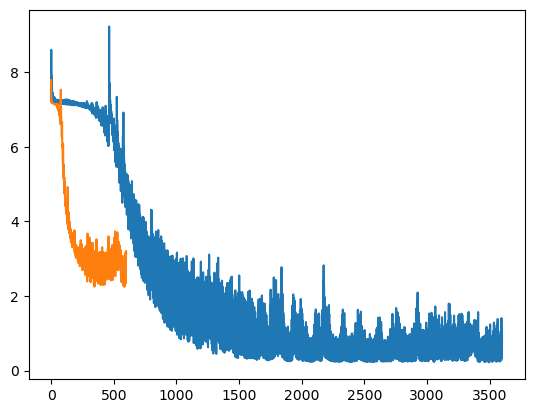

In [ ]:
plot_losses = [list(map(lambda v: numpy(v), l)) for l in [train_losses, test_losses]]
plot_losses[0][0]
plt.plot(plot_losses[0])
plt.plot(plot_losses[1])
plt.show()

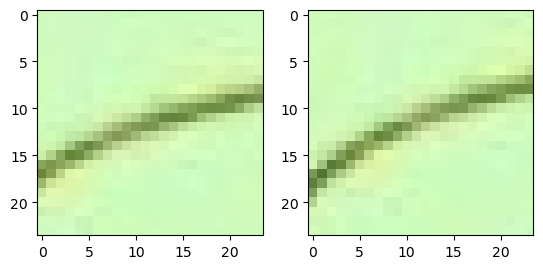

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(numpy(to_im(vec_to_im((train_xs[0][0])))))
axs[1].imshow(numpy(to_im(vec_to_im((train_xs[0][1])))))

In [ ]:
image = get_padded_image("./juneau2k.jpg", window).to("cuda")

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
torch.nn.functional.mse_loss(torch.ones(1, 2), torch.tensor([[0, 1]]))

tensor(0.5000)

In [ ]:
tt(train_xs)

list (67655)
    |__Tensor (dtype: torch.float32)
        |  (device: cpu)
        |__dim_0 (2)
        |__dim_1 (1728)


Ans: [-4.05551801  1.10605037]
Model ans: [-3.6745126  1.204524 ]


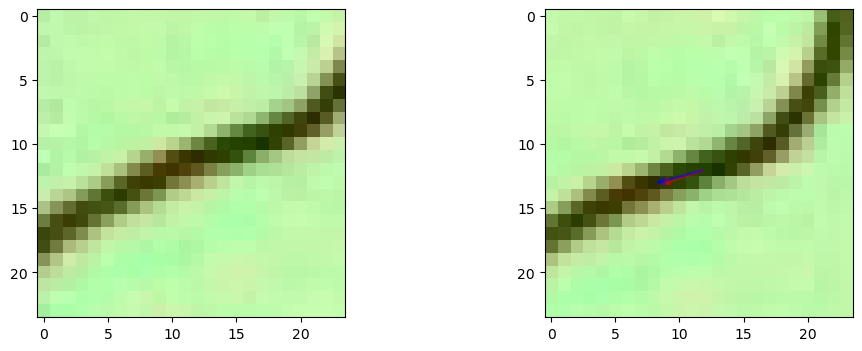

In [ ]:
index = torch.randint(0, len(train_xs), (1, 1))
compare_model_answer_with_actual(model, (train_xs[index], train_ys[index]), window)

Ans: [ 0.83633298 -2.13729539]
Model ans: [ 0.853858 -3.699937]


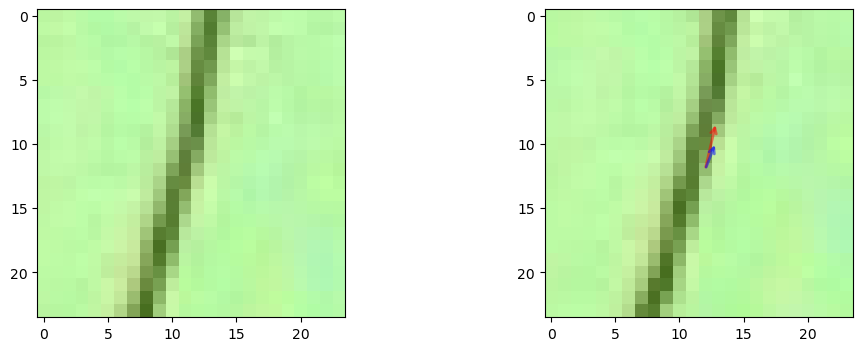

In [ ]:
index = torch.randint(0, len(test_xs), (1, 1))
compare_model_answer_with_actual(model, (test_xs[index], test_ys[index]), window)

In [ ]:
tt(train_xs[0])

Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (2)
    |__dim_1 (1728)


In [ ]:
model(train_xs[0].to("cuda").unsqueeze(0))

tensor([[[ 0.6608, -0.0069],
         [-3.4137,  1.0832]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
test_xs[index]

tensor([[0.7647, 0.7686, 0.7608,  ..., 0.6549, 0.6549, 0.6745],
        [0.7569, 0.7569, 0.7490,  ..., 0.6706, 0.6784, 0.6627]])

In [ ]:
plt.subplots

<function matplotlib.pyplot.subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, width_ratios=None, height_ratios=None, subplot_kw=None, gridspec_kw=None, **fig_kw)>

In [ ]:
tt(train_xs[0])
tt(train_ys[0])

Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (2)
    |__dim_1 (1728)
Tensor (dtype: torch.float64)
    |  (device: cpu)
    |__dim_0 (2)


Ans: [-3.09167411  0.98371449]
Model ans: [-3.413691  1.083162]


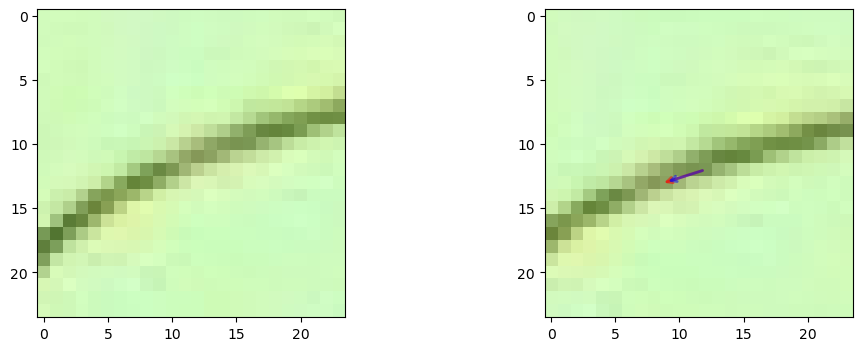

In [ ]:
compare_model_answer_with_actual(model, (train_xs[0], train_ys[0]), window)

In [ ]:
def lineWalk(image, model, coordinates, iters, history=None):
    if history == None:
        history = [coordinates[0]]
        # history = []
    # input for this iter
    patches = extract_patches(image, coordinates, window, window).unsqueeze(0)

    model_guess = model(patches)[0, -1]
    tt(model_guess)
    if (model_guess.round().int() == torch.tensor([0, 0]).to("cuda")).all():
        print("Next model jump is (0,0). Done!")
        return history
    new_coordinates = torch.stack([coordinates[-1], coordinates[-1]])
    new_coordinates[-1] += model_guess

    history.append(new_coordinates[-1])
    if iters >= 1500:
        return history
    return lineWalk(image, model, new_coordinates, iters + 1, history=history)

In [ ]:
starting_coord = get_line(0)[0:2]

In [ ]:
walk = lineWalk(image, model, starting_coord.to("cuda"), 0, history=None)
walk = torch.stack(walk)
csvable_points = torch.cat([torch.ones(walk.shape[0], 1).to("cuda") * 0, walk], dim=1)
tt(csvable_points)
df = pd.DataFrame(numpy(csvable_points), columns=["index", "x", "y"])

df.to_csv("./model_walk.csv", index=False, header=False)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2)
Tensor

In [ ]:
get_line(0)

tensor([[4447.0476, 2554.6568],
        [4452.9834, 2554.3742],
        [4460.1911, 2554.3742],
        ...,
        [8664.7814, 4010.9600],
        [8667.4762, 4011.9822],
        [8669.7065, 4011.7964]], dtype=torch.float64)

In [ ]:
data = generate_all_data(
    "./juneau2k.jpg", range(1), window, window, rotations=False, flip=False, split=False
)

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
tt(data)

list (1371)
    |__tuple
        |__Tensor (dtype: torch.float32)
        |   |  (device: cpu)
        |   |__dim_0 (2)
        |   |__dim_1 (1728)
        |__Tensor (dtype: torch.float64)
            |  (device: cpu)
            |__dim_0 (2)


In [ ]:
index = 2
first_pic = to_im(vec_to_im(data[index][0][0]))
second_pic = to_im(vec_to_im(data[index][0][1]))
data[index][1]

tensor([ 4.8052, -1.1306], dtype=torch.float64)

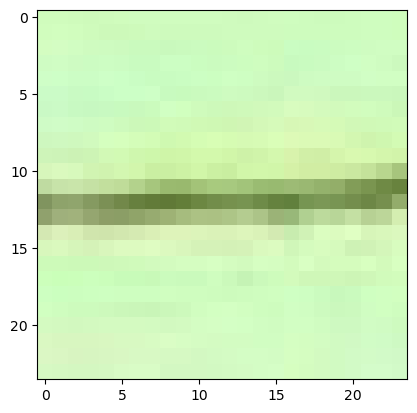

In [ ]:
plt.imshow(first_pic)

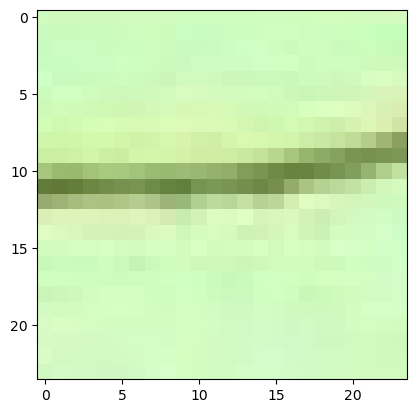

In [ ]:
plt.imshow(second_pic)

In [ ]:
data = generate_all_data(
    "./juneau2k.jpg", range(1), window, window, rotations=True, flip=True, split=False
)

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
tt(data)

list (10968)
    |__tuple
        |__Tensor (dtype: torch.float32)
        |   |  (device: cpu)
        |   |__dim_0 (2)
        |   |__dim_1 (1728)
        |__Tensor (dtype: torch.float64)
            |  (device: cpu)
            |__dim_0 (2)


In [ ]:
data[0][0]

tensor([[0.9529, 0.9569, 0.9647,  ..., 0.7412, 0.7412, 0.7412],
        [0.9490, 0.9255, 0.7451,  ..., 0.7451, 0.7490, 0.7490]])

In [ ]:
square_im1 = vec_to_im(data[-19][0][1])

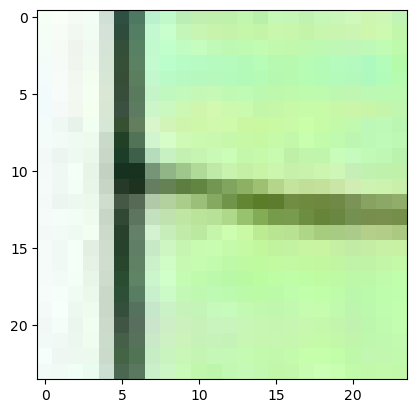

In [ ]:
plt.imshow(to_im(square_im1))

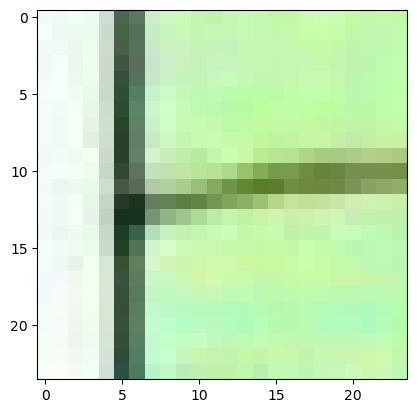

In [ ]:
plt.imshow(to_im(rotate_and_flip_image(square_im1, flip=True)))

Ans: [7.20776156 0.        ]
Model ans: [ 4.18894   -0.7800138]


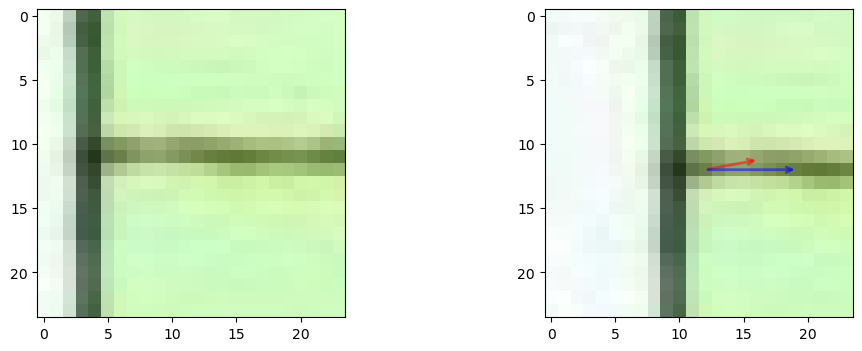

In [ ]:
index = 0
compare_model_answer_with_actual(model, (data[index][0], data[index][1]), window)